# Estudo do Pacote ASTSA usando Sentinel-1

## Importação

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import eetools, saveModule
from osgeo import gdal

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
coordenadas = "-48.53801472648439,-22.503806214013736,-48.270222978437516,-22.7281869567509"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2020-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])

latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

## Coleta



In [4]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)

In [5]:
sentinel1

Filtrando apenas VV e VH no modo IW

In [6]:
v_emit = sentinel1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                  .filter(ee.Filter.eq('instrumentMode', 'IW'))

Em quase todas as análises não tem imagens ascendentes

In [7]:
v_emit_asc = v_emit.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = v_emit.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

In [8]:
v_emit_desc

In [9]:
my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

Função para adicionar amplitude à uma imagem como nova banda

In [10]:
def add_amplitude(image, VV = "VV", VH = "VH"):
    amplitude = image\
        .expression('(VV ** 2 + VH ** 2) ** (1 / 2)', {'VV':image.select(VV), 'VH':image.select(VH)})\
        .rename('amplitude')
    return image.addBands(amplitude)

In [11]:
image = v_emit_desc.median()

image_amp = add_amplitude(image)
image_amp

In [12]:
my_map2 = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map2.addLayer(geom)

rgb = ee.Image.rgb(
    image_amp.select('VV'),
    image_amp.select('VH'),
    image_amp.select('amplitude')
).clip(geom)

my_map2.addLayer(rgb, {'min': [-30,-30,0], 'max': [1,1,2]})

In [13]:
def extrair_lonlat(imagem, geometria, bandas, scale=30):
    imagem = imagem.addBands(ee.Image.pixelLonLat())
    
    coordenadas = imagem.select(["longitude","latitude"] + bandas)\
        .reduceRegion(reducer=ee.Reducer.toList(),
                     geometry=geometria,
                     scale=scale,
                     bestEffort=True)
    
    coordenadas = coordenadas.getInfo()
    
    return pd.DataFrame.from_dict(coordenadas)

In [14]:
image = ee.Image(dummy_value).blend(v_emit_desc.map(add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

df = extrair_lonlat(image, geom, image_names, scale=10)
df

,S1A_IW_GRDH_1SDV_20200104T083855_20200104T083920_030648_03832D_B27B_amplitude,S1A_IW_GRDH_1SDV_20200116T083854_20200116T083919_030823_03894C_C5F9_amplitude,S1A_IW_GRDH_1SDV_20200128T083854_20200128T083919_030998_038F78_F944_amplitude,S1A_IW_GRDH_1SDV_20200209T083854_20200209T083919_031173_03958F_9F83_amplitude,S1A_IW_GRDH_1SDV_20200221T083853_20200221T083918_031348_039B92_202E_amplitude,S1A_IW_GRDH_1SDV_20200304T083853_20200304T083918_031523_03A1A2_1555_amplitude,S1A_IW_GRDH_1SDV_20200316T083854_20200316T083919_031698_03A7B1_4449_amplitude,S1A_IW_GRDH_1SDV_20200328T083854_20200328T083919_031873_03ADDA_F477_amplitude,S1A_IW_GRDH_1SDV_20200409T083854_20200409T083919_032048_03B40A_F2B5_amplitude,S1A_IW_GRDH_1SDV_20200421T083855_20200421T083920_032223_03BA2D_B3D6_amplitude,S1A_IW_GRDH_1SDV_20200503T083855_20200503T083920_032398_03C056_F102_amplitude,S1A_IW_GRDH_1SDV_20200515T083856_20200515T083921_032573_03C5DA_8E40_amplitude,S1A_IW_GRDH_1SDV_20200527T083857_20200527T083922_032748_03CB29_3369_amplitude,S1A_IW_GRDH_1SDV_20200608T083857_20200608T083922_032923_03D051_2713_amplitude,S1A_IW_GRDH_1SDV_20200620T083858_20200620T083923_033098_03D59D_873E_amplitude,S1A_IW_GRDH_1SDV_20200702T083858_20200702T083923_033273_03DAEA_5A4C_amplitude,S1A_IW_GRDH_1SDV_20200714T083859_20200714T083924_033448_03E041_3A07_amplitude,S1A_IW_GRDH_1SDV_20200726T083900_20200726T083925_033623_03E5A1_DEB5_amplitude,S1A_IW_GRDH_1SDV_20200807T083901_20200807T083926_033798_03EB1F_F571_amplitude,S1A_IW_GRDH_1SDV_20200819T083901_20200819T083926_033973_03F144_11D1_amplitude,S1A_IW_GRDH_1SDV_20200831T083902_20200831T083927_034148_03F76D_8BE7_amplitude,S1A_IW_GRDH_1SDV_20200912T083903_20200912T083928_034323_03FD8E_4620_amplitude,S1A_IW_GRDH_1SDV_20200924T083903_20200924T083928_034498_0403BB_84CC_amplitude,S1A_IW_GRDH_1SDV_20201006T083903_20201006T083928_034673_0409E6_53DC_amplitude,S1A_IW_GRDH_1SDV_20201018T083903_20201018T083928_034848_04100A_74ED_amplitude,S1A_IW_GRDH_1SDV_20201030T083903_20201030T083928_035023_0415F4_73C5_amplitude,S1A_IW_GRDH_1SDV_20201111T083903_20201111T083928_035198_041C17_DD4C_amplitude,S1A_IW_GRDH_1SDV_20201123T083903_20201123T083928_035373_042222_26AF_amplitude,S1A_IW_GRDH_1SDV_20201205T083902_20201205T083927_035548_042828_DC7D_amplitude,S1A_IW_GRDH_1SDV_20201217T083902_20201217T083927_035723_042E31_4146_amplitude,S1A_IW_GRDH_1SDV_20201229T083901_20201229T083926_035898_043452_2EF1_amplitude,latitude,longitude
0,20.716899,20.341120,22.451369,20.125621,22.192122,20.203974,19.356166,22.090348,22.759075,22.956831,24.463395,22.056820,23.452489,23.641790,18.915615,21.595083,23.839048,25.550558,21.120868,18.473427,28.728186,23.570329,21.744015,26.911320,27.203558,22.534765,23.874732,18.702302,20.510357,19.160141,18.494387,-22.728118,-48.537906
1,17.694414,17.669109,20.035479,19.080890,19.392424,21.617007,17.728264,16.188380,16.311598,15.271240,18.132579,17.330853,20.053076,16.046932,17.134724,16.894753,15.990419,19.164442,17.723786,15.476955,15.187911,14.918689,17.685273,18.567384,14.285951,18.710707,16.081257,16.385917,16.867936,15.478335,20.750575,-22.728118,-48.537461
2,16.131689,17.903040,16.490825,14.340238,17.315019,16.366185,15.205005,13.381444,15.944717,17.096541,15.849858,15.668229,18.423274,16.970591,13.896851,16.141005,16.210273,15.740026,17.347937,15.351120,16.088417,14.993604,15.269980,14.892600,17.511547,17.137704,18.151758,15.751512,13.467632,15.235117,13.068701,-22.728118,-48.537016
3,18.224191,16.481674,17.167379,17.574950,15.313163,15.982812,15.785406,16.163242,18.392932,16.991408,17.690281,15.887583,19.256036,16.689913,15.789385,17.070304,16.467159,18.373626,16.784947,15.961389,14.653778,15.154504,15.438388,17.149274,17.194140,15.841260,17.354306,19.122995,16.517664,17.168179,15.123768,-22.728118,-48.536570
4,16.114590,15.305584,18.093339,15.302582,17.670867,17.392273,16.526430,17.759688,15.582288,15.461505,15.988893,17.685384,18.356685,14.998029,15.351951,16.513497,14.395676,16.135025,19.109762,17.715408,16.333669,14.985637,14.5

## Exportando

In [15]:
from src import saveModule

In [16]:
export = df.iloc[:,[0,1,2,31,32]]
export_columns = list(export.drop(['latitude','longitude'], axis = 1).columns)
export_columns

['S1A_IW_GRDH_1SDV_20200104T083855_20200104T083920_030648_03832D_B27B_amplitude',
 'S1A_IW_GRDH_1SDV_20200116T083854_20200116T083919_030823_03894C_C5F9_amplitude',
 'S1A_IW_GRDH_1SDV_20200128T083854_20200128T083919_030998_038F78_F944_amplitude']

In [17]:
saveModule.save_tiff_from_df(
    export,
    export_columns,
    99999,
    "assets/amplitude.tif",
    "EPSG:4326"   
)

True

In [18]:
from osgeo import gdal
filepath = r"assets/amplitude.tif"
raster = gdal.Open(filepath)
type(raster)

osgeo.gdal.Dataset

In [19]:
raster.RasterCount

3

In [20]:
array = raster.GetRasterBand(3).ReadAsArray()
array.shape

(504, 602)

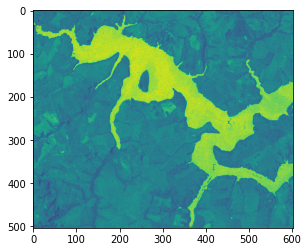

In [21]:
plt.imshow(array)

## Análise de Série Temporal

In [22]:
y = df.drop(['latitude','longitude'], axis=1).iloc[0,:]

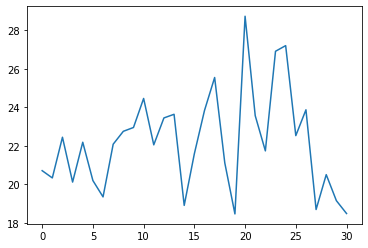

In [23]:
plt.plot(range(0,len(y)), y)

In [24]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects

rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

astsa = importr('astsa')
base = importr('base')
stats = importr('stats')

In [25]:
def get_specenv(x, *args): 
    scaled_time_series  = base.scale(stats.ts(robjects.FloatVector(list(x)))).ravel()
    arrays = [i(scaled_time_series) for i in args]
    arrays.insert(0, scaled_time_series)
    arrays = np.stack(arrays, axis=1)

    spec_env = astsa.specenv(arrays, real=True, plot=False)
    num_coefs = spec_env[:,2:].shape[1]
    names_col = ['frequency', 'specenv'] + [f"coef{i}" for i in range(1, num_coefs+1)]

    
    return pd.DataFrame(spec_env, columns=names_col)

In [26]:
get_specenv(y, np.abs, lambda k: k ** 2)

,frequency,specenv,coef1,coef2,coef3
0,0.03125,0.256243,-0.326228,-0.925448,0.192669
1,0.06250,0.125678,0.163892,-0.883082,0.439666
2,0.09375,0.108472,0.491790,-0.844879,0.210528
3,0.12500,0.151301,0.505804,0.658813,-0.556892
4,0.15625,0.059849,-0.232764,-0.859726,0.454635
5,0.18750,0.113780,-0.153539,-0.851434,0.501483
6,0.21875,0.181750,0.470011,-0.863226,-0.184202
7,0.25000,0.156898,-0.081166,-0.884594,0.459245
8,0.28125,0.271290,-0.206747,-0.944504,0.255279
9,0.31250,0.198087,-0.182296,-0.980399,0.074740


In [116]:
nrows = 1000

coords = df.head(nrows).loc[:,['latitude','longitude']]
df_specenv = df.head(nrows).drop(['latitude', 'longitude'], axis=1)
df_specenv['specenv'] = df_specenv.apply(lambda x: get_specenv(x, np.abs, lambda x: x ** 2), axis = 1)
df_specenv = df_specenv.join(coords)

df_specenv.loc[1,'specenv']

,frequency,specenv,coef1,coef2,coef3
0,0.03125,0.180646,0.441007,-0.817935,0.369453
1,0.06250,0.079961,0.257338,-0.957040,0.133607
2,0.09375,0.082685,0.405634,0.813055,-0.417616
3,0.12500,0.128362,-0.087895,-0.883584,0.459950
4,0.15625,0.223133,0.389254,-0.745768,0.540659
5,0.18750,0.206658,0.024678,-0.934699,0.354583
6,0.21875,0.225494,-0.094167,-0.902047,0.421240
7,0.25000,0.190980,0.177280,-0.967823,0.178578
8,0.28125,0.204430,-0.020242,-0.990794,0.133858
9,0.31250,0.260697,-0.036449,-0.862165,0.505315


In [127]:
row = 995

get_specenv(df.drop(['latitude','longitude'], axis=1).iloc[row,:], np.abs, lambda x: x**2)
df.loc[row, ['latitude', 'longitude']]

latitude    -22.727673
longitude   -48.362905
Name: 995, dtype: float64

In [149]:
nrows = 10000

coords = df.head(nrows).loc[:, ['latitude','longitude']]
df_specenv = df.head(nrows).drop(['latitude','longitude'], axis=1)

series = df_specenv.apply(lambda x: get_specenv(x, np.abs, lambda y: y**2).loc[:, 'coef1'], axis=1)
specenv_image = series.join(coords)

specenv_image

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,latitude,longitude
0,-0.326228,0.163892,0.491790,0.505804,-0.232764,-0.153539,0.470011,-0.081166,-0.206747,-0.182296,-0.071789,0.399242,-0.308747,-0.078579,-0.006924,0.668455,-22.728118,-48.537906
1,0.441007,0.257338,0.405634,-0.087895,0.389254,0.024678,-0.094167,0.177280,-0.020242,-0.036449,0.171847,0.336277,0.668868,-0.339550,-0.151008,0.407293,-22.728118,-48.537461
2,0.300420,0.059499,-0.075458,0.583146,0.379992,0.073085,0.045199,0.202249,0.267243,0.018013,-0.166164,0.276173,0.004423,0.534002,-0.138999,0.135123,-22.728118,-48.537016
3,-0.183176,0.094419,0.314774,-0.416670,-0.114579,0.189542,0.429851,0.057971,-0.020499,0.044291,0.273450,0.010153,0.170684,0.170089,-0.101345,0.062219,-22.728118,-48.536570
4,0.449946,0.145789,-0.076252,-0.068545,0.301908,0.007428,0.066031,0.645247,-0.059090,0.470030,-0.000815,0.070590,0.082459,-0.130925,0.369006,-0.121341,-22.728118,-48.536125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.292685,0.423703,0.200790,-0.066387,-0.116195,-0.079297,0.061904,0.250822,0.325203,0.234179,-0.135512,-0.061383,0.244466,0.338279,0.178467,0.156449,-22.720994,-48.376264
9996,-0.128471,-0.019817,0.317676,0.169764,0.249195,-0.058466,-0.344713,0.065691,0.147824,-0.007985,-0.129795,-0.016110,-0.080428,0.066644,-0.064843,0.076965,-22.720994,-48.375819
9997,-0.086879,0.133093,0.025551,0.405136,0.141049,-0.123353,0.051770,0.341431,-0.006453,-0.070969,0.860038,0.172704,-0.362252,-0.028176,-0.019021,-0.279327,-22.720994,-48.375373
9998,-0.007131,-0.493451,-0.174048,0.313756,0.056807,0.098415,0.336849,-0.371911,0.100275,0.406322,0.031682,0.008193,0.030356,0.367859,-0.008181,0.028219,-22.720994,-48.374928


In [150]:
specenv_image_columns = list(specenv_image.drop(['latitude','longitude'], axis = 1).columns)
specenv_image_columns

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [151]:
saveModule.save_tiff_from_df(
    specenv_image,
    specenv_image_columns,
    99999,
    "assets/specenv.tif",
    "EPSG:4326"   
)

True

In [152]:
filepath = r"assets/specenv.tif"
raster = gdal.Open(filepath)
type(raster)

osgeo.gdal.Dataset

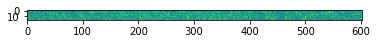

In [153]:
array = raster.GetRasterBand(16).ReadAsArray()
plt.imshow(array)